In [1]:
import os
from contextlib import suppress
from random import random, randrange

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from faker import Faker
from gensim.models import Word2Vec
from tensorflow.keras import datasets, layers, models
from tqdm import tqdm

from string2image.generate import GenerateFromPairs
from string2image.preprocessing import String2Image

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Let's match some acronyms.
*The dataset being used can be found [here](https://gist.githubusercontent.com/philshem/5d2d8c76c671afb8ae3c6bdb1617f228/raw/201096a941c5a58d171014abda88b1918b00e8a6/clean_AcronymFile.csv)*

We will will read in the dataset, split by comma and use the explode method to help generate pairs of correct acronym mappings

In [2]:
w2v_model = Word2Vec.load("word2vec.model")
df = pd.read_csv("../data/acronyms.csv", sep="\t").dropna()
df["definition"] = df["definition"].str.split(",")
df_exploded = df.explode("definition").dropna()
df_exploded = df_exploded[df_exploded["definition"] != ""]
data_pairs = list(df_exploded.itertuples(index=False))
g = GenerateFromPairs(data_pairs)

#### The rest of the code is mostly the same as the Comparing strings notebook, so I refer you to there for an explanation

In [3]:
size = 5000
train_data = list(g.random_pair_gen(size))
test_data = list(g.random_pair_gen(size))
# Sloppy way of ensuring out test data does not appear in our train data
test_data = [d for d in test_data if d not in train_data]
# Ensure there are enough testing samples left.
print(len(test_data))

4393


In [4]:
def get_features(s1, s2, model):
    left = String2Image(s1, model, array_size=(32, 32), flatten=False, mode="RGB")
    right = String2Image(s2, model, array_size=(32, 32), flatten=False, mode="RGB")
    return left - right

def arrange_values(data):
    data = map(lambda x: get_features(x.left, x.right, w2v_model), data)
    data = np.array(list(data))
    return data

def arrange_labels(labels):
    labels = map(lambda x: np.array(np.int(x.is_match)).reshape(1,), labels)
    labels = np.array(list(labels))
    return labels

train_images, test_images = arrange_values(train_data), arrange_values(test_data)
train_labels, test_labels = arrange_labels(train_data), arrange_labels(test_data)

train_images, test_images = train_images / 255.0, test_images / 255.0

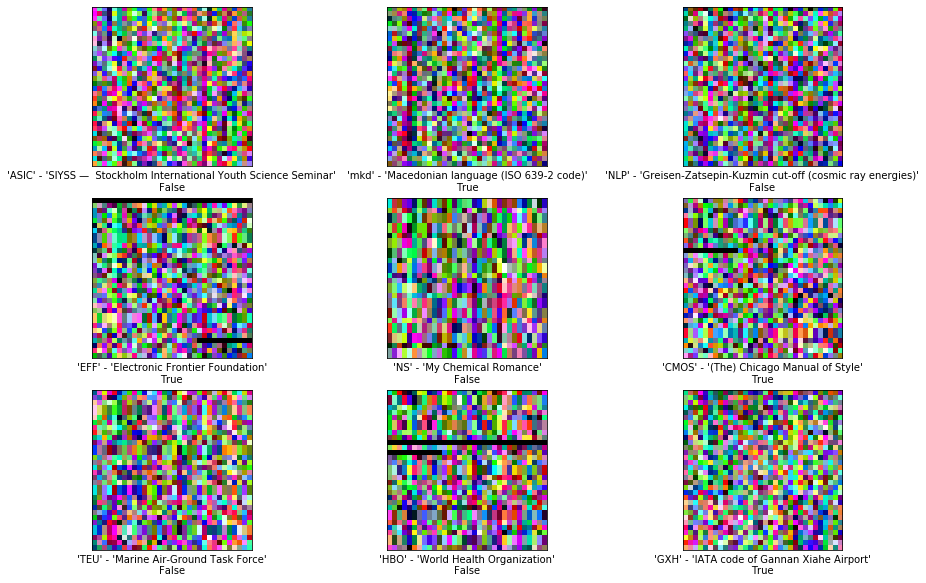

In [5]:
plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    label = f"'{train_data[i].left}' - '{train_data[i].right}'\n{train_data[i].is_match}"
    plt.xlabel(label)
plt.show()

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels))


Epoch 1/5
157/157 [==============================] - 1s 8ms/step - loss: 0.5982 - accuracy: 0.6608 - val_loss: 0.4487 - val_accuracy: 0.8186
Epoch 2/5
157/157 [==============================] - 1s 5ms/step - loss: 0.4649 - accuracy: 0.8020 - val_loss: 0.4530 - val_accuracy: 0.8204
Epoch 3/5
157/157 [==============================] - 1s 5ms/step - loss: 0.4557 - accuracy: 0.8046 - val_loss: 0.4513 - val_accuracy: 0.8204
Epoch 4/5
157/157 [==============================] - 1s 5ms/step - loss: 0.4539 - accuracy: 0.8032 - val_loss: 0.4414 - val_accuracy: 0.8211
Epoch 5/5
157/157 [==============================] - 1s 5ms/step - loss: 0.4454 - accuracy: 0.8046 - val_loss: 0.4504 - val_accuracy: 0.8209


#### In summary, this demonstrates an application of this technique to domain specific fuzzy comparisons. 

## Some samples of the incorrectly classified pairs
### The false negatives
As you can see some of these are not really acronyms. In a real world example we could do some more cleaning of the original data.

In [8]:
examine = pd.DataFrame(test_data)
predictions = pd.DataFrame(model.predict(test_images))
examine["val"] = predictions[0] < predictions[1]
true = examine[examine["is_match"]]
true[true["is_match"] != true["val"]]

,left,right,is_match,val
10,BRB,"""Combat Reconnaissance Patrol Vehicle"") †[2]",True,False
19,CNA,and American (Casualty Company),True,False
40,PPASSCCATAG,Seniors,True,False
55,ATC,Air Traffic Control-Air Training Corps-U.S. Ai...,True,False
61,MET,Middle European Time,True,False
...,...,...,...,...
4352,CID,designs,True,False
4355,FRR,"""Romanian Amateur Radio Federation"")",True,False
4357,OMA,Army,True,False
4374,ICHTHYS,Theou Yios,True,False


### And the false positives

In [9]:
false = examine[~examine["is_match"]]
false[false["is_match"] != false["val"]]

,left,right,is_match,val
9,lin,Anti Slip Regulation,False,True
34,PC,Continental (Casualty Company),False,True
49,ces,Madison Square Garden (either the 1879,False,True
60,NAAQS,Old Age Pensioner (UK),False,True
78,NMCS,Niger (ISO 3166 trigram),False,True
...,...,...,...,...
4253,DC,Dual-Purpose Improved Conventional Munition,False,True
4302,CSA,Christine's,False,True
4317,CPF,Small Computer System Interface (“scuzzy”),False,True
4360,tr,Very Short Range Air Defence,False,True
